In [331]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils

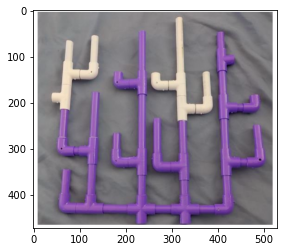

In [332]:
img1 = cv2.imread('D:\F -  DISK\Downloads\colony1.PNG')
img2 = cv2.imread('D:\F -  DISK\Downloads\colony2.PNG')
img2_copy= np.copy(img2)
plt.imshow(img1)

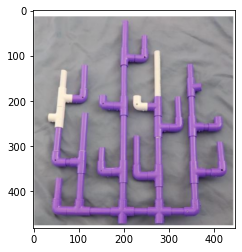

In [333]:
plt.imshow(img2)

In [334]:
# colors
lw=np.array([50,20,180], dtype=np.uint8)
uw=np.array([150,110,255], dtype=np.uint8)
up = np.array([255,255,255],  dtype=np.uint8)
lp =np.array([120,83,118], dtype=np.uint8)

In [335]:
img1_hsv=np.copy(img1)
img1_hsv = cv2.cvtColor(img1_hsv , cv2.COLOR_BGR2HSV)

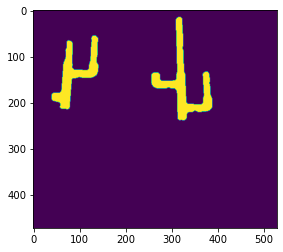

In [336]:
white1 = cv2.inRange(img1_hsv,lw,uw)
white1 = cv2.medianBlur(white1,7)
plt.imshow(white1)

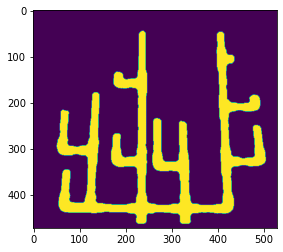

In [337]:
pink1= cv2.inRange(img1_hsv,lp,up)
pink1= cv2.medianBlur(pink1,9)
plt.imshow(pink1)

In [338]:
h,w,_= img1.shape
img2= cv2.resize(img2, (w,h), interpolation = cv2.INTER_AREA)
img2_hsv=np.copy(img2)
img2_copy= np.copy(img2)
img2_hsv = cv2.cvtColor(img2_hsv , cv2.COLOR_BGR2HSV)

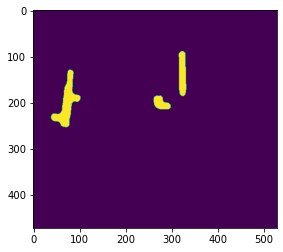

In [339]:
white2 = cv2.inRange(img2_hsv,lw,uw)
white2 = cv2.medianBlur(white2,9)
plt.imshow(white2)

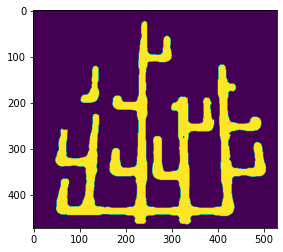

In [340]:
pink2= cv2.inRange(img2_hsv,lp,up)
pink2= cv2.medianBlur(pink2,9)
plt.imshow(pink2)

In [341]:
# Apply Sift Algorithm
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance: ## determine good matches 
        good.append(m)

In [342]:
MIN_MATCH =10
if len(good)>MIN_MATCH:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, MASK = cv2.findHomography(src_pts,dst_pts,cv2.RANSAC,5.0)
    matchesMask = white1.ravel().tolist()
    h,w,_ = img1.shape
    im_out = cv2.warpPerspective(img1, M, (img2.shape[1],img2.shape[0]))
    diff = cv2.subtract (im_out, img2)
    
else:
    print('not enough matches')

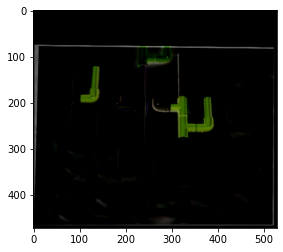

In [343]:
plt.imshow(diff)

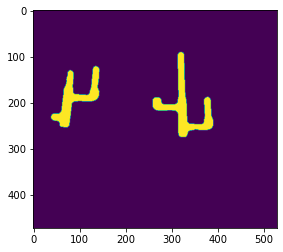

In [344]:
# recalculate after homo
white= np.copy(im_out)
white= cv2.cvtColor(im_out, cv2.COLOR_BGR2HSV)
white= cv2.inRange(white,lw,uw)
white= cv2.medianBlur(white,9)
plt.imshow(im_out_white)

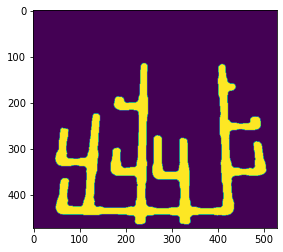

In [345]:
pink= np.copy(im_out)
pink=cv2.cvtColor(im_out, cv2.COLOR_BGR2HSV)
pink= cv2.inRange(pink,lp,up)
pink= cv2.medianBlur(pink,9)
plt.imshow(pink)

In [346]:
# draw Rect
def draw_rectangle(img , color,text):
    contours, hir = cv2.findContours(img,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        area = cv2.contourArea(c)
        if area > 100:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(img2_copy, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img2_copy,text,(x + 0, y + 0),cv2.FONT_HERSHEY_COMPLEX,0.7,color,2)
    return img2_copy

In [347]:
kernel = np.ones((4,4),np.uint8)
and_im_out = cv2.bitwise_or(white,pink)
and_img2= cv2.bitwise_or(white2,pink2)

In [348]:
xor_pink= cv2.bitwise_xor(and_im_out,and_img2)
xor_pink = cv2.morphologyEx(xor_pink , cv2.MORPH_OPEN ,kernel)

In [349]:
#Areas of growth should be outlined with a green overlay
growth= cv2.bitwise_and(xor_pink,pink2)
update =  draw_rectangle(growth,(0, 255,0),"GROWTH")

In [350]:
#Areas of damage or death should be outlined with a yellow
damage = cv2.bitwise_and(xor_pink,pink)
update  = draw_rectangle(damage,(0,255,200),"DAMAGE")

In [351]:
xor_white = cv2.bitwise_xor(white2,white)
xor_white = cv2.morphologyEx(xor_white , cv2.MORPH_OPEN ,kernel)

In [352]:
#Areas that have recovered from bleaching/blotching should be outlined with a blue 
recovery = cv2.bitwise_and(xor_white,pink2)
update = draw_rectangle(recovery,(255,0,0),"RECOVERY")

In [353]:
#Areas of bleaching/blotching should be outlined with a red overlay
bleach = cv2.bitwise_and(xor_white,pink)
update = draw_rectangle(bleach,(0,0,255),"Bleach")

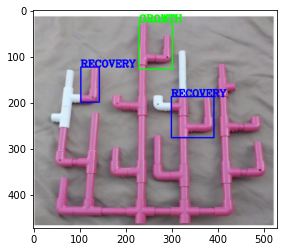

In [354]:
plt.imshow(imutils.opencv2matplotlib(update))